### Imports

In [1]:
import argparse
import os.path as osp

import torch
import torch.nn.functional as F
from torch.nn import Linear

import torch_geometric.transforms as T
from torch_geometric.datasets import MovieLens
from torch_geometric.nn import SAGEConv, to_hetero

import matplotlib.pyplot as plt

import pathlib
import os
import sys
parent_path = pathlib.Path(os.getcwd()).parent.absolute()
sys.path.append(str(parent_path))
from utils.Neo4jMovieLensMetaData import Neo4jMovieLensMetaData
from utils.gnn_simple import Model
from utils.visualize import plot_loss, plot_test

/Users/ioannisathanasiou/diploma/environ/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


path = osp.join(osp.dirname(osp.abspath('')), '../../data/MovieLensNeo4jMetaData')
dataset = Neo4jMovieLensMetaData(
    path,
    model_name='all-MiniLM-L6-v2',
    database_url="bolt://localhost:7687",
    database_username="neo4j",
    database_password="admin",
    force_pre_process=True,
    force_db_restore=False,
    text_features=["title", "original_title"],
    list_features=[],
    fastRP_features=[],
    numeric_features=[],
    node2vec_features=[],
    SAGE_features=[],
)

data = dataset[0].to(device)
# Add user node features for message passing:
data['user'].x = torch.eye(data['user'].num_nodes, device=device)
del data['user'].num_nodes

# Add a reverse ('movie', 'rev_rates', 'user') relation for message passing:
data = T.ToUndirected()(data)
del data['movie', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.

# Perform a link-level split into training, validation, and test edges:
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)(data)

Processing...


Movies have features...
Encoding title...
Encoding original_title...
[torch.Size([2055, 384]), torch.Size([2055, 384])]


Done!


### Model

In [3]:
class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['user'][row], z_dict['movie'][col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

### Train-test functions

In [4]:
def train_test(model, use_weighted_loss):
    latest_predictions = []

    if use_weighted_loss:
        weight = torch.bincount(train_data['user', 'movie'].edge_label)
        weight = weight.max() / weight
    else:
        weight = None

    def weighted_mse_loss(pred, target, weight=None):
        weight = 1. if weight is None else weight[target].to(pred.dtype)
        return (weight * (pred - target.to(pred.dtype)).pow(2)).mean()

    with torch.no_grad():
        model.encoder(train_data.x_dict, train_data.edge_index_dict)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


    def train():
        model.train()
        optimizer.zero_grad()
        pred = model(train_data.x_dict, train_data.edge_index_dict,
                    train_data['user', 'movie'].edge_label_index)
        target = train_data['user', 'movie'].edge_label
        loss = weighted_mse_loss(pred, target, weight)
        loss.backward()
        optimizer.step()
        return float(loss)


    @torch.no_grad()
    def test(data):
        nonlocal latest_predictions
        model.eval()
        pred = model(data.x_dict, data.edge_index_dict,
                    data['user', 'movie'].edge_label_index)
        pred = pred.clamp(min=0, max=5)
        latest_predictions = pred
        target = data['user', 'movie'].edge_label.float()
        rmse = F.mse_loss(pred, target).sqrt()
        return float(rmse)

    for epoch in range(1, 50):
        loss = train()
        train_rmse = test(train_data)
        val_rmse = test(val_data)
        test_rmse = test(test_data)
        if not epoch % 5:
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
                f'Val: {val_rmse:.4f}, Test: {test_rmse:.4f}')
    
    return latest_predictions


### Experiments on balanced DB with 165K ratings with weighted and unweighted loss

Epoch: 005, Loss: 5.4532, Train: 1.3389, Val: 1.3332, Test: 1.3348
Epoch: 010, Loss: 4.5897, Train: 1.7568, Val: 1.7520, Test: 1.7436
Epoch: 015, Loss: 4.2681, Train: 1.3304, Val: 1.3255, Test: 1.3253
Epoch: 020, Loss: 4.1741, Train: 1.3384, Val: 1.3341, Test: 1.3337
Epoch: 025, Loss: 4.1901, Train: 1.4253, Val: 1.4219, Test: 1.4194
Epoch: 030, Loss: 3.9666, Train: 1.2587, Val: 1.2576, Test: 1.2616
Epoch: 035, Loss: 3.7234, Train: 1.3515, Val: 1.3523, Test: 1.3516
Epoch: 040, Loss: 3.4681, Train: 1.2158, Val: 1.2229, Test: 1.2261
Epoch: 045, Loss: 3.1884, Train: 1.2392, Val: 1.2536, Test: 1.2544


(array([ 332., 1416., 2517., 2844., 2834., 2879., 2231., 1141.,  271.,
          23.]),
 array([1.13752067, 1.49751985, 1.85751891, 2.21751809, 2.57751727,
        2.93751645, 3.29751563, 3.65751457, 4.01751375, 4.37751293,
        4.73751211]),
 <BarContainer object of 10 artists>)

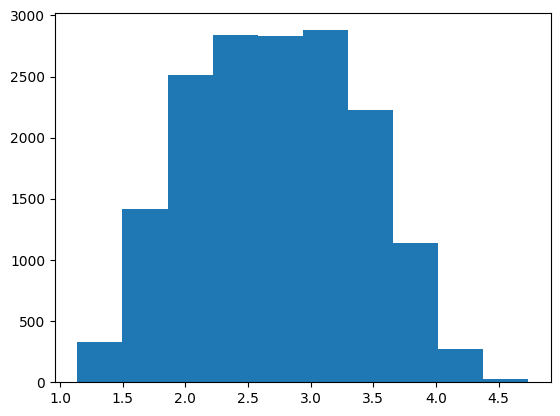

In [5]:
model = Model(hidden_channels=32).to(device)
preds = train_test(model, use_weighted_loss=True)
plt.hist(preds)

Epoch: 005, Loss: 2.6955, Train: 1.7999, Val: 1.7974, Test: 1.8078
Epoch: 010, Loss: 2.4039, Train: 1.5353, Val: 1.5309, Test: 1.5249
Epoch: 015, Loss: 1.8781, Train: 1.4263, Val: 1.4255, Test: 1.4334
Epoch: 020, Loss: 1.7072, Train: 1.3372, Val: 1.3361, Test: 1.3345
Epoch: 025, Loss: 1.5975, Train: 1.2635, Val: 1.2665, Test: 1.2704
Epoch: 030, Loss: 1.5499, Train: 1.2344, Val: 1.2406, Test: 1.2426
Epoch: 035, Loss: 1.5044, Train: 1.2101, Val: 1.2213, Test: 1.2223
Epoch: 040, Loss: 1.4295, Train: 1.1818, Val: 1.2010, Test: 1.2024
Epoch: 045, Loss: 1.3592, Train: 1.1559, Val: 1.1835, Test: 1.1821


(array([ 294., 1547., 2693., 2885., 2848., 2499., 2070., 1295.,  332.,
          25.]),
 array([1.58632147, 1.90594769, 2.22557402, 2.54520035, 2.86482668,
        3.18445277, 3.5040791 , 3.82370543, 4.14333153, 4.46295786,
        4.78258419]),
 <BarContainer object of 10 artists>)

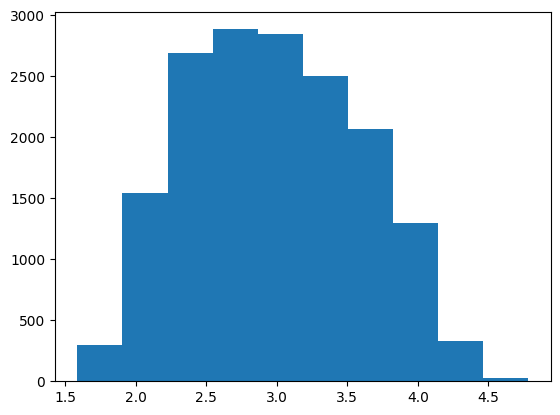

In [6]:
model = Model(hidden_channels=32).to(device)
preds = train_test(model, use_weighted_loss=False)
plt.hist(preds)